# Initial Model Analysis

Analysis of ResNet models (without KD)

In [1]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as pyo
pyo.init_notebook_mode()
import plotly.io as pio
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None
import math
import re
plt.rcParams['figure.dpi'] = 300

## Load ResNet Data

In [2]:
experiments = ["resnet/archives/ft", "resnet/archives/ft_load", "resnet/archives/ft_sampling", "resnet/archives/ft_sampling_load", "resnet/archives/train"]
models = ["resnet18", "resnet34", "resnet50", "resnet101"]
seeds = [42, 43, 44]
results_path = '../../results/ham10000/'

test_data = []
val_data = []


for exp in experiments:
    for model in models:
        for seed in seeds:
            
            # Add teacher model "NaN"
            path = results_path + exp + '/'+ model + "_s" + str(seed) 
            df_tmp = pd.read_csv(path + '_test.csv')
            df_tmp.insert(0, "seed", seed)
            df_tmp.insert(0, "experiment", exp)
            df_tmp.insert(0, "teacher_experiment",  np.nan)
            df_tmp.insert(0, "teacher_model",  np.nan)
            df_tmp.insert(0, "model", model)
            test_data.append(df_tmp)
            
            df_tmp = pd.read_csv(path + '_val.csv')
            df_tmp.insert(0, "seed", seed)
            df_tmp.insert(0, "experiment", exp)
            df_tmp.insert(0, "teacher_experiment", np.nan)
            df_tmp.insert(0, "teacher_model",  np.nan)
            df_tmp.insert(0, "model", model)
            val_data.append(df_tmp)
        
resnet_test_df = pd.concat(test_data)    
resnet_val_df = pd.concat(val_data)

## Load KD Data

In [3]:
experiments = ["kd/archives/ft", "kd/archives/ft_sampling", "kd/archives/train", "kd/archives/train_sample"]
teacher_models = [('resnet101', 'resnet101_sample', 'resnet/archives/ft_sampling_load', 'r101-sam1-s43'),
                  ('resnet101', 'resnet101', 'resnet/ft_load', 'r101-sam0-s43'),
                  ('resnet50', 'resnet50_sample', 'resnet/archives/ft_sampling_load', 'r50-sam1-s44')]
student_models = ['resnet18', 'resnet34']
seeds = [42, 43, 44]
results_path = '../../results/ham10000/'

test_data = []


for exp in experiments:
    for model in student_models:
        for teacher_tuple in teacher_models:
            for seed in seeds:
                teacher, teacher_path_name , teacher_exp, teacher_id = teacher_tuple

                if 'train' in exp:
                    path = results_path + exp + '/t_' + teacher_path_name + "_s_" + model + "_s" + str(seed) 
                else:
                    if 'sampling' in exp:
                        path = results_path + exp + '/r' + re.search(r'\d+', model).group() + '-sam1-kd1-s' + str(seed) + '_' +  teacher_id
                    else:
                        path = results_path + exp + '/r' + re.search(r'\d+', model).group() + '-sam0-kd1-s' + str(seed) + '_' + teacher_id
                  
                
                df_tmp = pd.read_csv(path + '/test.csv')
                df_tmp['seed'] = seed
                df_tmp.insert(0, "experiment", exp)
                df_tmp.insert(0, "teacher_experiment", teacher_exp)
                df_tmp.insert(0, "teacher_model", teacher_path_name)
                df_tmp.insert(0, "model", model)
                test_data.append(df_tmp)


kd_test_df = pd.concat(test_data)    

## Put them together

In [5]:
test_df = pd.concat([resnet_test_df, kd_test_df], ignore_index=True)

### Dicts for plots

In [6]:
experiment_colors = {
    "resnet/ft": "violet",
    "resnet/ft_load": "gold",
    "resnet/ft_sampling": "lime",
    "resnet/ft_sampling_load": "olive",
    "resnet/train": "steelblue",
    "kd/ft": "cyan",
    "kd/ft_sampling": "orange",
    "kd/train": "orchid",
    "kd/train_sample": "darkred",
}

experiment_labels = {
    "resnet/ft": "ResNet:\nFine-tuning",
    "resnet/ft_load": "ResNet:\nFine-tuning + loading",
    "resnet/ft_sampling": "ResNet:\nFine-tuning + sampling",
    "resnet/ft_sampling_load": "ResNet:\nFine-tuning + sampling + loading",
    "resnet/train": "ResNet:\nTraining",
    "kd/ft": "KD:\nFine-tuning",
    "kd/ft_sampling": "KD:\nFine-tuning + sampling",
    "kd/train": "KD:\nTraining",
    "kd/train_sample": "KD:\nTraining + sampling",
}

## Models Performance

In [7]:
def avg_model_performance(data, models, experiments, metric, bar_width=0.15, line_length=0.05):
    
    # filter out models and experiments (lists)
    data = data.loc[data['model'].isin(models)]
    data = data.loc[data['experiment'].isin(experiments)]
    avg_scores = data.groupby(['model', 'experiment']).mean().reset_index()
                            
    # Set up graphical variables
    total_bars = len(experiments)
    bar_group_width = bar_width * total_bars
    legend_handles = []
    legend_labels = []

    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create the plot
    for i, model in enumerate(models):
        model_scores = []
        for j, experiment in enumerate(experiments):
            scores = data[(data['model'] == model) & (data['experiment'] == experiment)][metric]
            mean_score = avg_scores[(avg_scores['model'] == model) & (avg_scores['experiment'] == experiment)][metric]
            min_score = scores.min()
            max_score = scores.max()
            yerr = [mean_score - min_score, max_score - mean_score]
            model_scores.append(mean_score)
            x_pos = i - bar_group_width/2 + (j + 0.5) * bar_width  # Calculate the x position
            handle = ax.errorbar(x_pos, mean_score, yerr=yerr, marker='o', markersize=10, markerfacecolor=experiment_colors[experiment], markeredgecolor='black', ecolor='gray', linewidth=0.9, label=experiment_labels[experiment])

            # Add little grey hotizontal lines on the error lines
            ax.hlines(mean_score + max_score - mean_score, x_pos - line_length/2, x_pos + line_length/2, color='black', linewidth=0.9)
            ax.hlines(mean_score - mean_score + min_score, x_pos - line_length/2, x_pos + line_length/2, color='black', linewidth=0.9)

            # Legend stuff
            if experiment_labels[experiment] not in legend_labels:
                legend_handles.append(handle)
                legend_labels.append(experiment_labels[experiment])

    # Customize the plot
    ax.set_xticks(np.arange(len(models)))
    ax.set_xticklabels(models, fontsize=15)
    ax.set_ylabel(metric, fontsize=15) 
    # Set the x-axis limits to show all the error bars
    ax.set_xlim(-bar_group_width/2, len(models)-1+bar_group_width/2)
    ax.set_facecolor('#F0F0F0')
    # Legend
    ax.legend(handles=legend_handles, labels=legend_labels, bbox_to_anchor=(1.02, 1), loc='upper left', handlelength=2.0, handletextpad=0.5)
    # Grid
    ax.yaxis.grid(True, linestyle='dotted', linewidth=0.8, color='white', alpha=1)
    # Title
    fig.suptitle('ResNets comparison with different training techniques', fontsize=15, y=0.95)

    plt.show()
    

/tmp/ipykernel_2675503/801986455.py:6: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



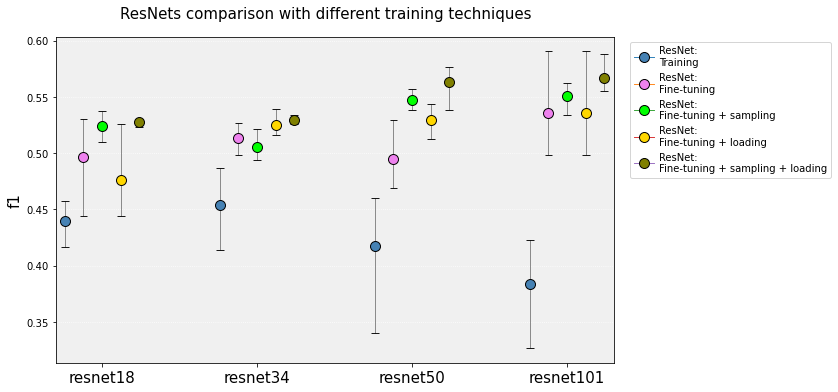

/tmp/ipykernel_2675503/801986455.py:6: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



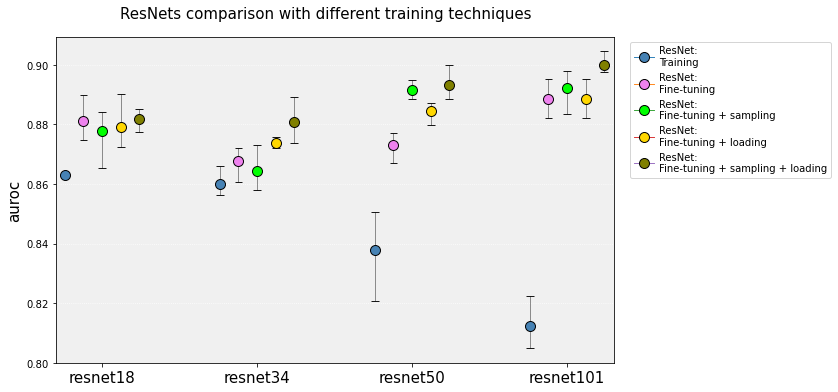

/tmp/ipykernel_2675503/801986455.py:6: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



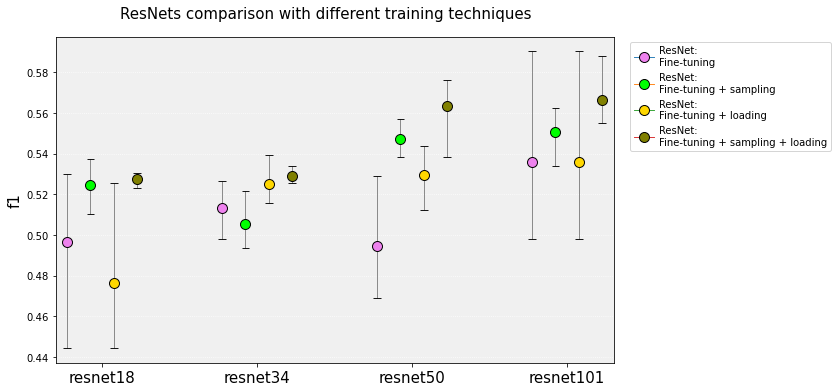

/tmp/ipykernel_2675503/801986455.py:6: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



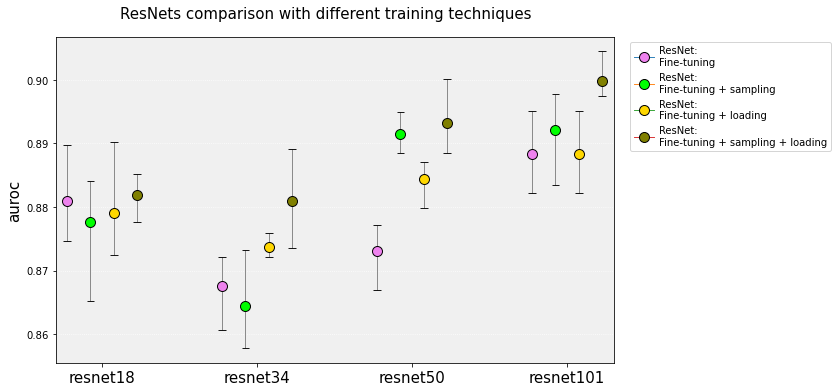

In [7]:
# Plot
avg_model_performance(test_df, 
                      ['resnet18', 'resnet34', 'resnet50', 'resnet101'], 
                      ['resnet/train', 'resnet/ft', 'resnet/ft_sampling', 'resnet/ft_load', 'resnet/ft_sampling_load'], 
                      'f1', 
                      bar_width=0.12)

avg_model_performance(test_df, 
                      ['resnet18', 'resnet34', 'resnet50', 'resnet101'], 
                      ['resnet/train', 'resnet/ft', 'resnet/ft_sampling', 'resnet/ft_load', 'resnet/ft_sampling_load'], 
                      'auroc',
                      bar_width=0.12)

avg_model_performance(test_df,
                      ['resnet18', 'resnet34', 'resnet50', 'resnet101'], 
                      ['resnet/ft', 'resnet/ft_sampling', 'resnet/ft_load', 'resnet/ft_sampling_load'], 
                      'f1')
avg_model_performance(test_df, 
                      ['resnet18', 'resnet34', 'resnet50', 'resnet101'], 
                      ['resnet/ft', 'resnet/ft_sampling', 'resnet/ft_load', 'resnet/ft_sampling_load'],  
                      'auroc')


/tmp/ipykernel_3572771/801986455.py:6: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



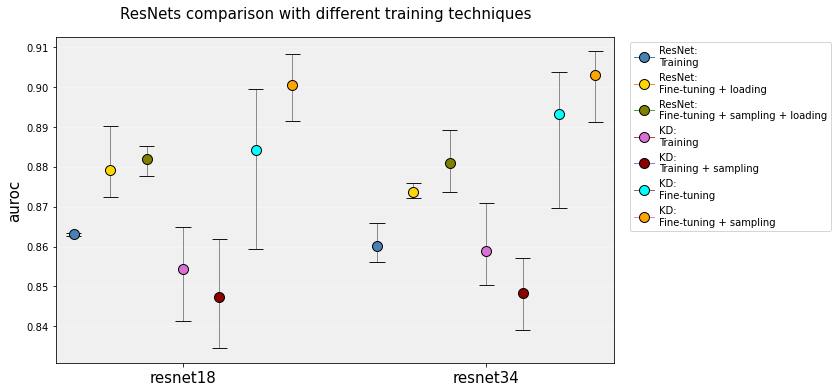

/tmp/ipykernel_3572771/801986455.py:6: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



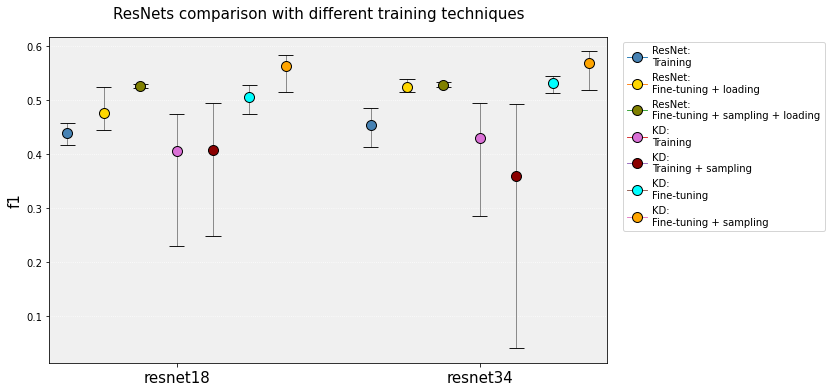

/tmp/ipykernel_3572771/801986455.py:6: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



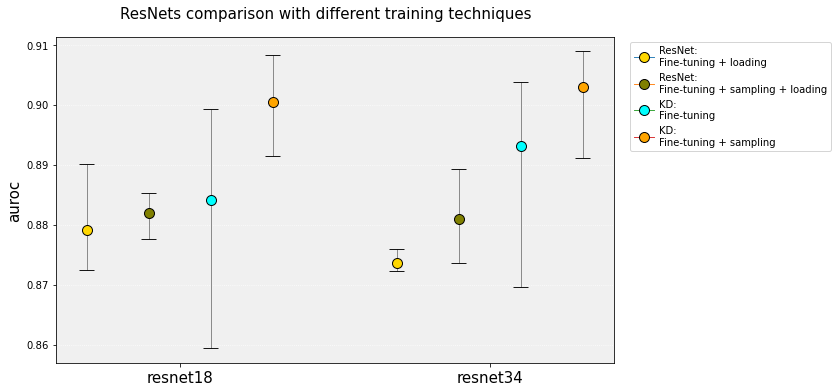

/tmp/ipykernel_3572771/801986455.py:6: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



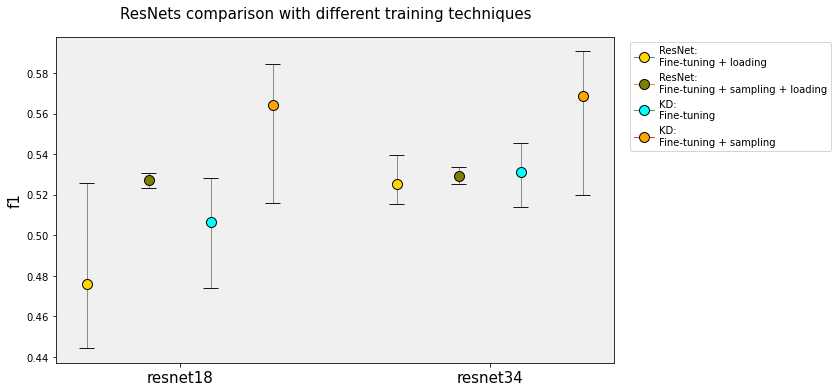

In [27]:

# Filtering the experiments where the teacher was trained without sampling and the student was trained with sampling based on the teacher (very low performance)
tmp_df = test_df.drop(test_df[(test_df['teacher_experiment'] == 'resnet/ft_load') & (test_df['experiment'] == 'kd/ft_sampling')].index)


avg_model_performance(tmp_df, 
                      ['resnet18', 'resnet34'], 
                      ['resnet/train', 'resnet/ft_load', 'resnet/ft_sampling_load', 'kd/train', 'kd/train_sample', 'kd/ft', 'kd/ft_sampling'], 
                      'auroc',
                      bar_width=0.12)

avg_model_performance(tmp_df, 
                      ['resnet18', 'resnet34'], 
                      ['resnet/train', 'resnet/ft_load', 'resnet/ft_sampling_load', 'kd/train', 'kd/train_sample', 'kd/ft', 'kd/ft_sampling'], 
                      'f1',
                      bar_width=0.12)

avg_model_performance(tmp_df, 
                      ['resnet18', 'resnet34'], 
                      ['resnet/ft_load', 'resnet/ft_sampling_load', 'kd/ft', 'kd/ft_sampling'], 
                      'auroc',
                      bar_width=0.2)


avg_model_performance(tmp_df, 
                      ['resnet18', 'resnet34'], 
                      ['resnet/ft_load', 'resnet/ft_sampling_load', 'kd/ft', 'kd/ft_sampling'], 
                      'f1',
                      bar_width=0.2)

# TODO:
# - Would be good to add the line that gives the avg performance of teacher models

## ResNet Detailed Performance Comparison

In [15]:
def get_metric(df, model, experiment, metric):
    return df[(df['model'] == model) & (df['experiment'] == experiment)][metric].iloc[0]

def plot_resnet_performance(df, 
                            experiments, 
                            metric = 'f1', 
                            title = 'model comparison', 
                            show_baseline=True, 
                            exp_label_1='Teacher Resnet18-Resnet152',
                            exp_label_2='Student Resnet18 w/ KD',
                            exp_label_3='',
                            exp_label_4=''):
    

    
    
    teacher_exp, student_exp, exp_3, exp_4 = experiments
    teacher_df = df[df['experiment'] == teacher_exp]
    student_df = df[df['experiment'] == student_exp]
    exp_3_df = df[df['experiment'] == exp_3]
    exp_4_df = df[df['experiment'] == exp_4]
    
    # Add average metric if there are multiple seeds (does not effect the code if there is only 1 seed)
    avg_metric = 'avg' + metric
    teacher_df[avg_metric] = teacher_df.groupby('model')[metric].transform('mean')
    student_df[avg_metric] = student_df.groupby('model')[metric].transform('mean')
    exp_3_df[avg_metric] = exp_3_df.groupby('model')[metric].transform('mean')
    exp_4_df[avg_metric] = exp_4_df.groupby('model')[metric].transform('mean')

    # Compute standard deviation for each group
    teacher_df['error'] = teacher_df.groupby('model')[metric].transform('std')
    student_df['error'] = student_df.groupby('model')[metric].transform('std')
    exp_3_df['error'] = exp_3_df.groupby('model')[metric].transform('std')
    exp_4_df['error'] = exp_4_df.groupby('model')[metric].transform('std')
        
    
    # Get the baseline (Teacher ResNet18)
    baseline = get_metric(teacher_df, 'resnet18', teacher_exp, avg_metric)
    
    fig, ax = plt.subplots(figsize=(7, 4))

    # Add error bars using errorbar function
    ax.errorbar(teacher_df['model'], teacher_df[avg_metric], yerr=teacher_df['error'], fmt='none', color='cadetblue', ecolor='cadetblue', elinewidth=0.5, capsize=3, label='_nolegend_')
    ax.errorbar(student_df['model'], student_df[avg_metric], yerr=student_df['error'] , fmt='none', color='indianred', ecolor='indianred', elinewidth=0.5, capsize=3, label='_nolegend_')
    ax.errorbar(exp_3_df['model'], exp_3_df[avg_metric], yerr=exp_3_df['error'], fmt='none', color='violet', ecolor='violet', elinewidth=0.5, capsize=3, label='_nolegend_')
    ax.errorbar(exp_4_df['model'], exp_4_df[avg_metric], yerr=exp_4_df['error'], fmt='none', color='gold', ecolor='gray', elinewidth=0.5, capsize=3, label='_nolegend_')
    
    # markers
    ax.scatter(teacher_df['model'], teacher_df[avg_metric], color='cadetblue', marker='^', edgecolor='black', alpha=0.8, label=exp_label_1, s=100, zorder=2)
    ax.scatter(student_df['model'], student_df[avg_metric], color='indianred', marker='o', edgecolor='black', alpha=0.8, label=exp_label_2, s=100, zorder=2)
    ax.scatter(exp_3_df['model'], exp_3_df[avg_metric], color='violet', marker='X', edgecolor='black', alpha=0.8, label=exp_label_3, s=100, zorder=2)
    ax.scatter(exp_4_df['model'], exp_4_df[avg_metric], color='gold', marker='D', edgecolor='black', alpha=0.8, label=exp_label_4, s=100, zorder=2)
    
    # baseline
    if show_baseline:
        ax.axhline(y=baseline, linestyle='-', color='black', label='Baseline: Resnet18 w/o KD', linewidth=0.7, zorder=1)
    
    # connect the markers
    ax.plot(teacher_df['model'], teacher_df[avg_metric], linestyle='dotted', color='grey', linewidth=1, zorder=1)
    ax.plot(student_df['model'], student_df[avg_metric], linestyle='dotted', color='grey', linewidth=1, zorder=1)
    ax.plot(exp_3_df['model'], exp_3_df[avg_metric], linestyle='dotted', color='grey', linewidth=1, zorder=1)
    ax.plot(exp_4_df['model'], exp_4_df[avg_metric], linestyle='dotted', color='grey', linewidth=1, zorder=1)


    # set y x
    ax.set_ylabel('F1', fontsize=12)
    ax.tick_params(axis='x', labelsize=12, labelrotation=30)
    ax.tick_params(axis='y', labelsize=8)
    
    # set legend
    # ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2, labelspacing=1, fontsize=10, facecolor='#F0F0F0', edgecolor='black')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), labelspacing=1, fontsize=10, facecolor='#F0F0F0', edgecolor='black')

    
    ax.set_facecolor('#F0F0F0')
    ax.yaxis.grid(True, linestyle='dotted', linewidth=0.8, color='white', alpha=1)
    
    # title
    fig.suptitle(title, fontsize=12, y=0.95)

    plt.show()

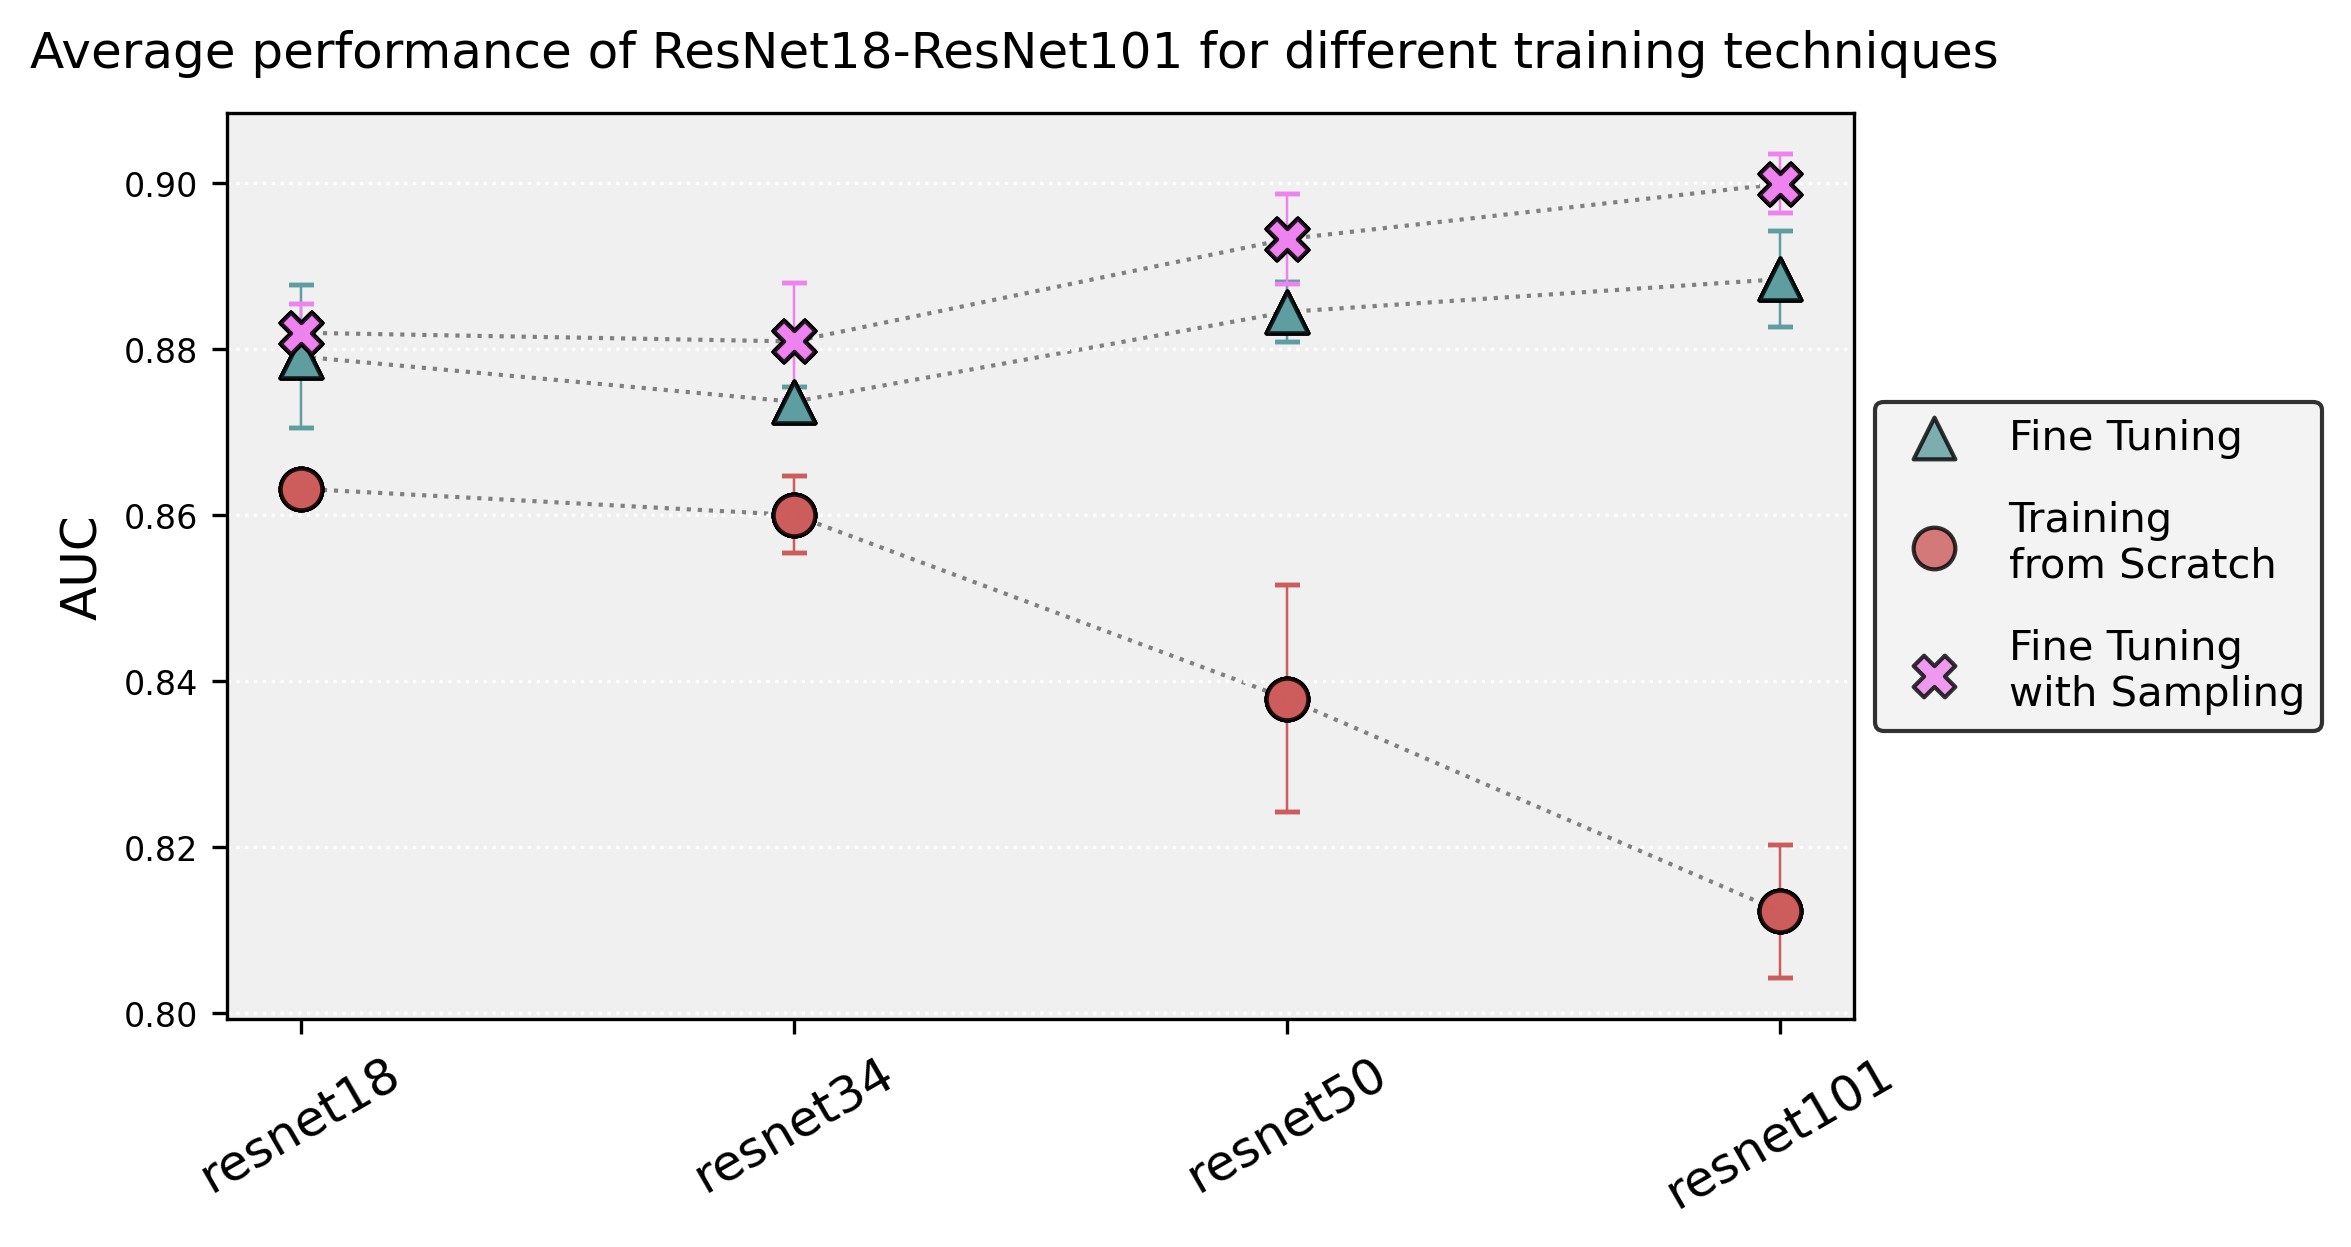

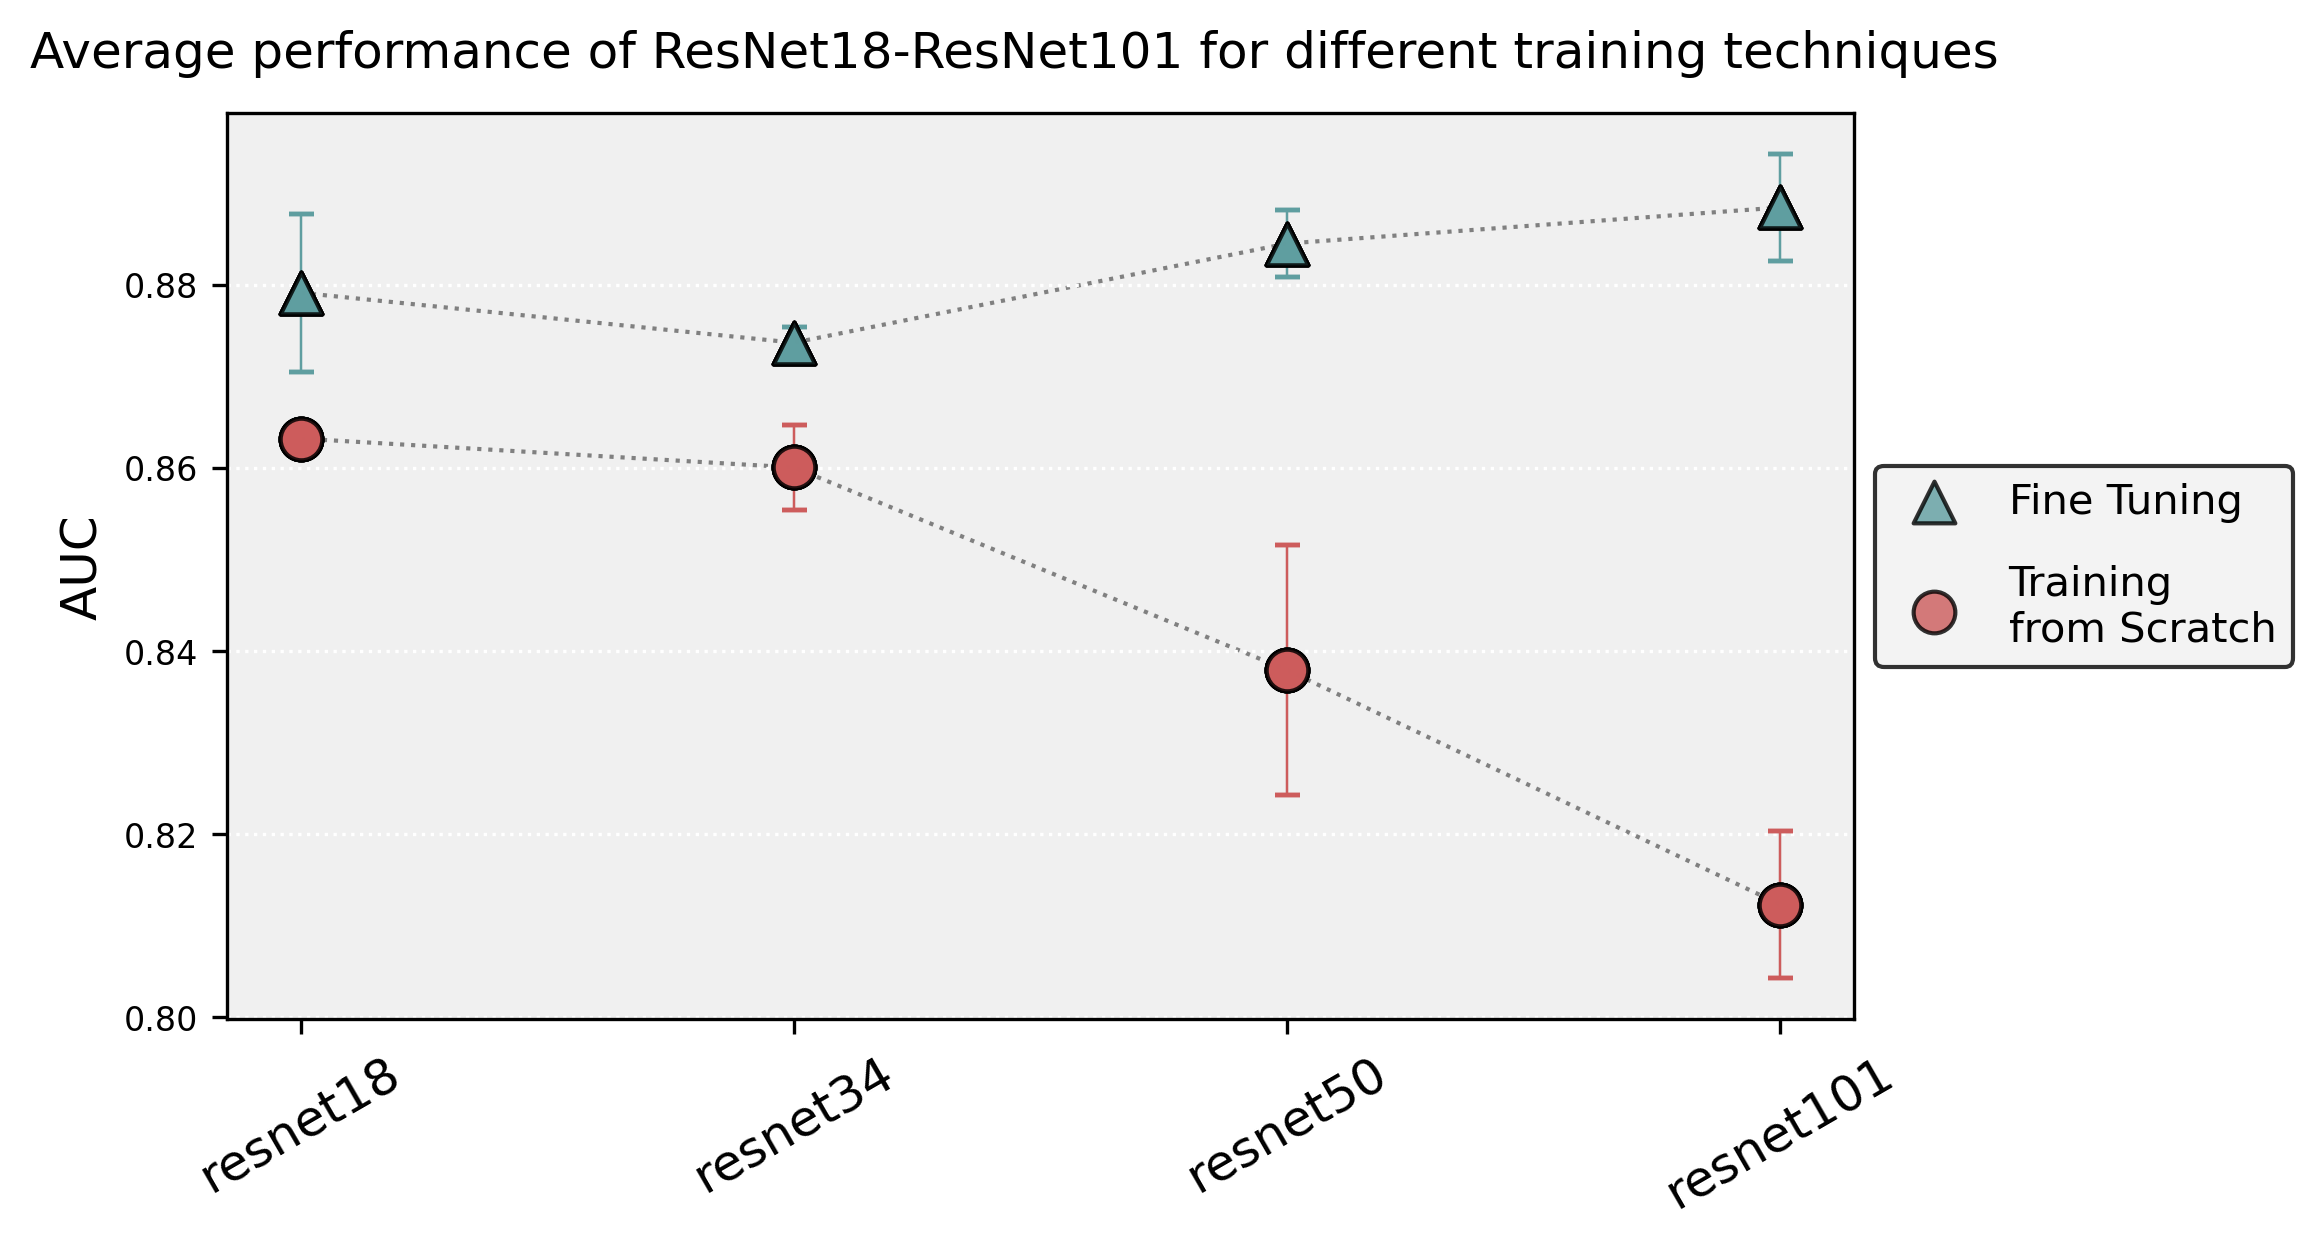

In [14]:
plt.rcParams['figure.dpi'] = 300

plot_resnet_performance(test_df, 
                        ('resnet/archives/ft_load', 'resnet/archives/train', 'resnet/archives/ft_sampling_load', ''), 
                        'auroc',
                        title='Average performance of ResNet18-ResNet101 for different training techniques', 
                        show_baseline=False, 
                        exp_label_1='Fine Tuning', 
                        exp_label_2='Training\nfrom Scratch',
                        exp_label_3='Fine Tuning\nwith Sampling', 
                        exp_label_4='')


plot_resnet_performance(test_df, 
                        ('resnet/archives/ft_load', 'resnet/archives/train', '', ''), 
                        'auroc',
                        title='Average performance of ResNet18-ResNet101 for different training techniques', 
                        show_baseline=False, 
                        exp_label_1='Fine Tuning', 
                        exp_label_2='Training\nfrom Scratch',
                        # exp_label_3='Fine Tuning\nwith Sampling', 
                        exp_label_4='')


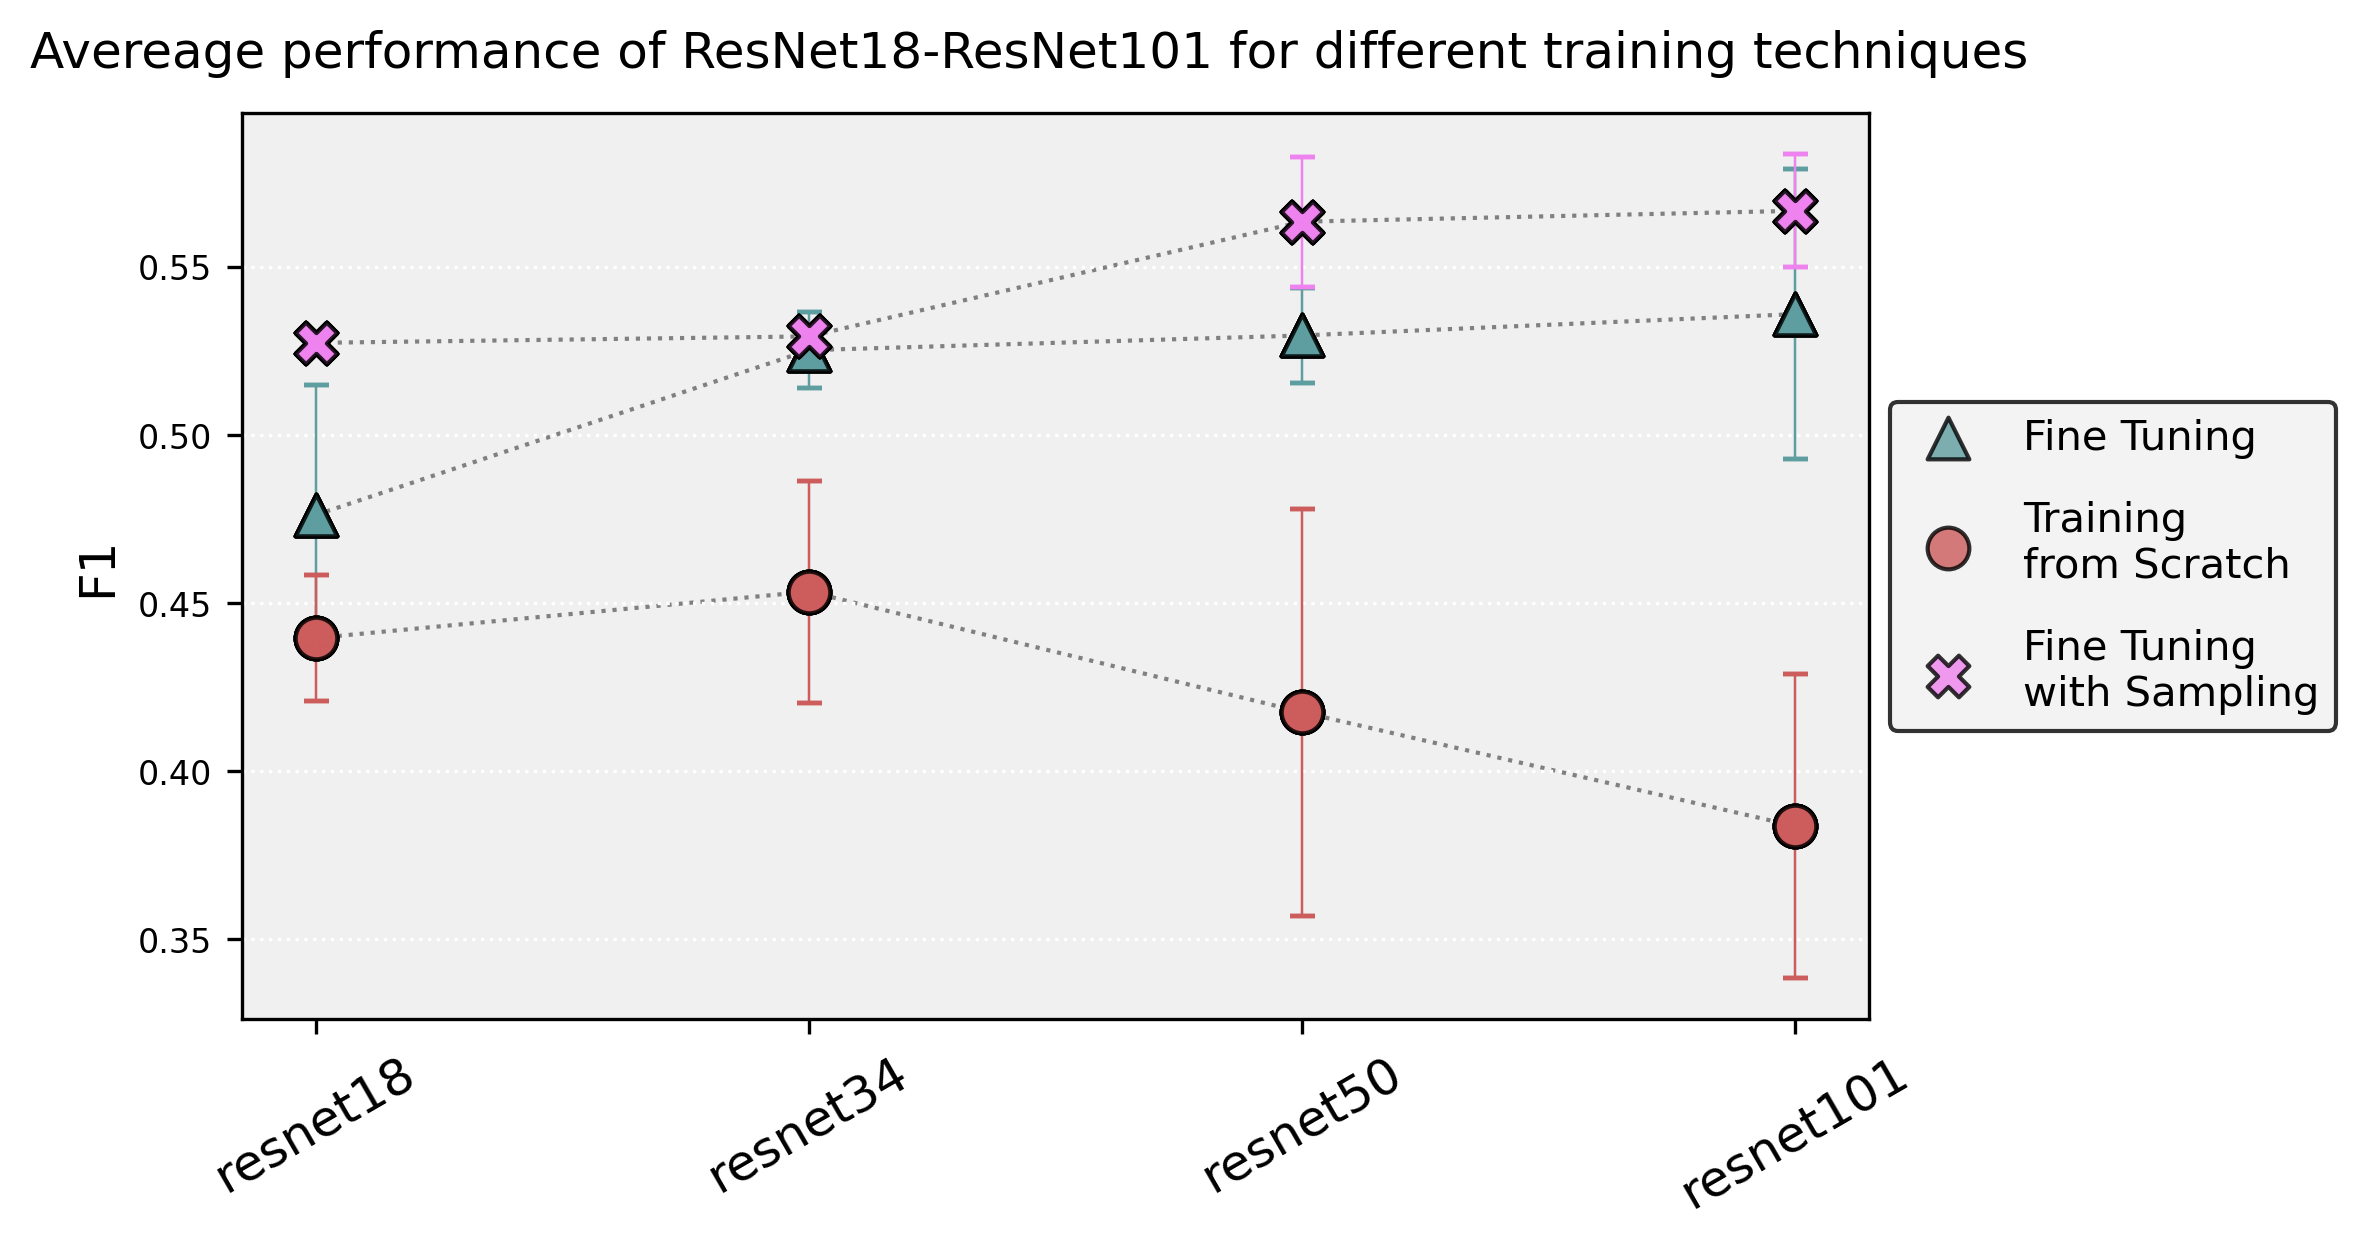

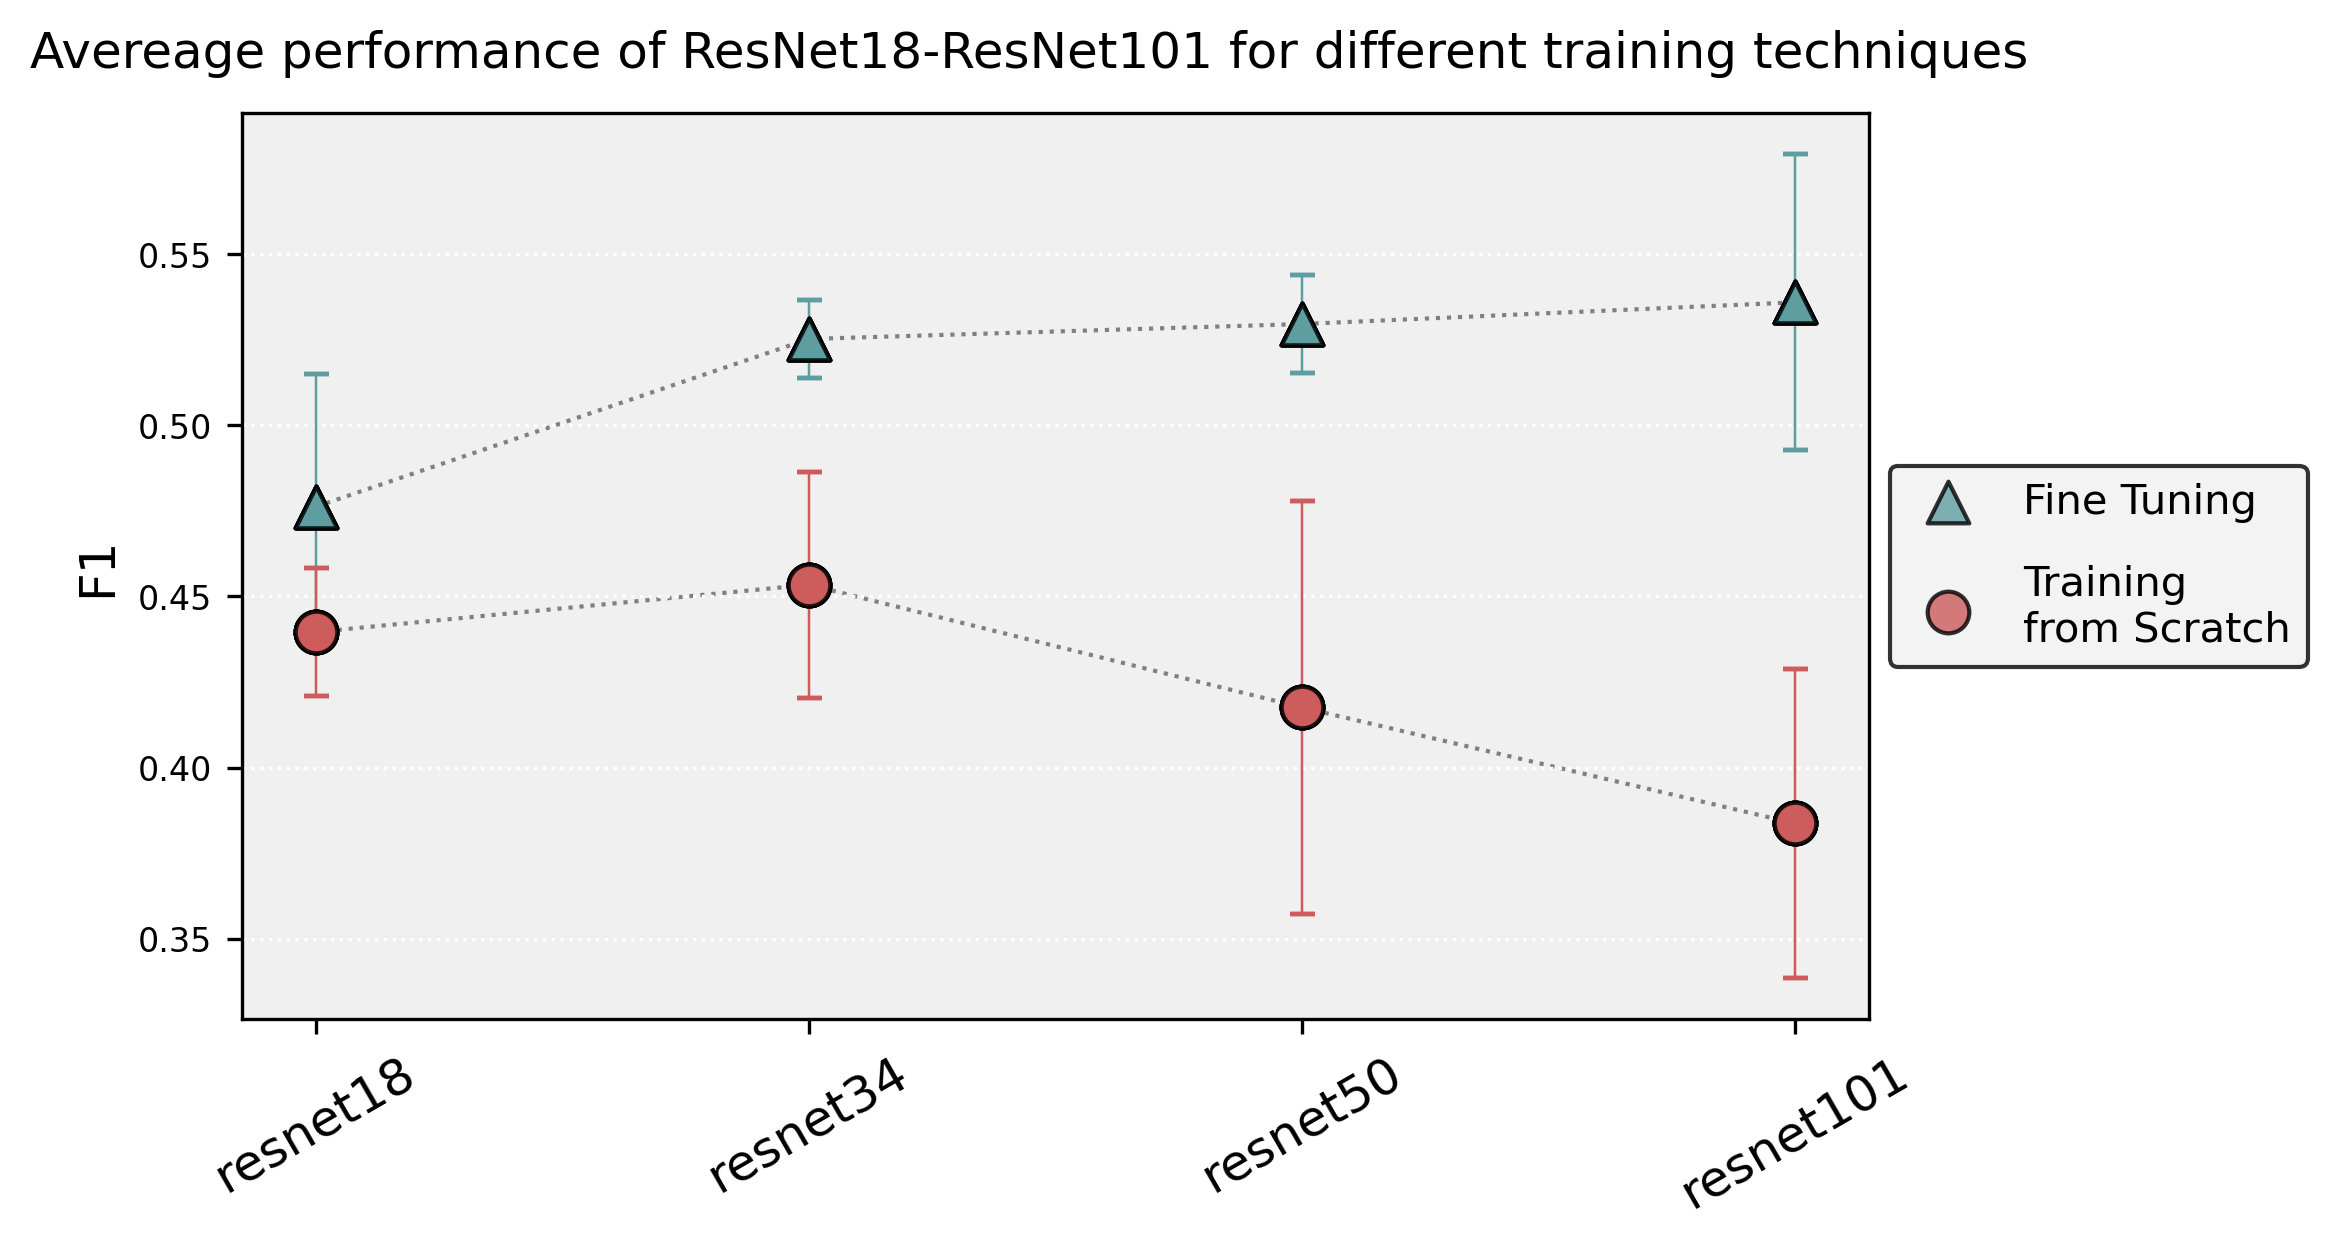

In [16]:
plot_resnet_performance(test_df, 
                        ('resnet/archives/ft_load', 'resnet/archives/train', 'resnet/archives/ft_sampling_load', ''), 
                        'f1',
                        title='Avereage performance of ResNet18-ResNet101 for different training techniques', 
                        show_baseline=False, 
                        exp_label_1='Fine Tuning', 
                        exp_label_2='Training\nfrom Scratch',
                        exp_label_3='Fine Tuning\nwith Sampling', 
                        exp_label_4='')


plot_resnet_performance(test_df, 
                        ('resnet/archives/ft_load', 'resnet/archives/train', '', ''), 
                        'f1',
                        title='Avereage performance of ResNet18-ResNet101 for different training techniques', 
                        show_baseline=False, 
                        exp_label_1='Fine Tuning', 
                        exp_label_2='Training\nfrom Scratch',
                        # exp_label_3='Fine Tuning\nwith Sampling', 
                        exp_label_4='')

## KD detailed comaprison

In [77]:
def get_metric(df, model, experiment, metric):
    return df[(df['model'] == model) & (df['experiment'] == experiment)][metric].mean()


def plot_kd_performance(df, 
                        experiments, 
                        teachers,
                        students,
                        metric = 'f1', 
                        title = 'model comparison', 
                        show_baseline=True, 
                        exp_label_1='Teacher Resnet18-Resnet152',
                        exp_label_2='Student Resnet18 w/ KD',
                        exp_label_3='',
                        exp_label_4=''):
    
    plt.rcParams['figure.dpi'] = 150
    
    teacher_exp, student_exp, exp_3, exp_4 = experiments

    teacher_data = []
    for teacher_params in teachers:
        teacher, exp, seed = teacher_params
        teacher_data.append(df[(df['model']==teacher) & (df['seed']==seed) & (df['experiment']==exp)])
                    
    teacher_df = pd.concat(teacher_data)   
    student_1_df = df[(df['experiment'] == student_exp) & (df['model'] == students[0])]
    student_2_df = df[(df['experiment'] == student_exp) & (df['model'] == students[1])]

    
    # Add average metric if there are multiple seeds (does not effect the code if there is only 1 seed)
    avg_metric = 'avg' + metric
    
    teacher_df[avg_metric] = teacher_df.groupby(['model', 'experiment', 'seed'])[metric].transform('mean') 
    student_1_df[avg_metric] = student_1_df.groupby(['model', 'teacher_model', 'teacher_experiment'])[metric].transform('mean')
    student_2_df[avg_metric] = student_2_df.groupby(['model', 'teacher_model', 'teacher_experiment'])[metric].transform('mean')
    
    # Format teacher_df (change the model names)
    teacher_df.loc[teacher_df['experiment'] == 'resnet/ft_sampling_load', 'model'] = teacher_df['model'] + "_sample"
    
    # Get the baseline (Teacher ResNet18)
    resnet_18_baseline = get_metric(df, 'resnet18', teacher_exp, metric)
    resnet_34_baseline = get_metric(df, 'resnet34', teacher_exp, metric)
    
    fig, ax = plt.subplots()
    
    teacher_df.sort_values(by=['model'], ascending=False, inplace=True)
    student_1_df.sort_values(by=['teacher_model'], ascending=False, inplace=True)
    student_2_df.sort_values(by=['teacher_model'], ascending=False, inplace=True)
    
    # markers
    ax.scatter(teacher_df['model'], teacher_df[avg_metric], color='cadetblue', marker='^', edgecolor='black', alpha=0.8, label=exp_label_1, s=100, zorder=2)
    ax.scatter(student_1_df['teacher_model'], student_1_df[avg_metric], color='indianred', marker='o', edgecolor='black', alpha=0.8, label=exp_label_2, s=100, zorder=2)
    ax.scatter(student_2_df['teacher_model'], student_2_df[avg_metric], color='gold', marker='D', edgecolor='black', alpha=0.8, label=exp_label_3, s=100, zorder=2)
    
    # baseline
    if show_baseline:
        ax.axhline(y=resnet_18_baseline, linestyle='-', color='indianred', label='Baseline: Avg Resnet18 w/o KD', linewidth=0.7, zorder=1)
        ax.axhline(y=resnet_34_baseline, linestyle='-', color='gold', label='Baseline: Avg Resnet34 w/o KD', linewidth=0.7, zorder=1)
    
    # connect the markers
    ax.plot(teacher_df['model'], teacher_df[avg_metric], linestyle='dotted', color='grey', linewidth=1, zorder=1)
    ax.plot(student_1_df['teacher_model'], student_1_df[avg_metric], linestyle='dotted', color='grey', linewidth=1, zorder=1)
    ax.plot(student_2_df['teacher_model'], student_2_df[avg_metric], linestyle='dotted', color='grey', linewidth=1, zorder=1)
    
#     ## set y range
#     y_min = min(teacher_df[avg_metric].min(), student_1_df[avg_metric].min(), student_2_df[avg_metric].min()) - 0.05
#     y_max = max(teacher_df[avg_metric].max(), student_1_df[avg_metric].max(), student_2_df[avg_metric].max()) + 0.05
#     ax.set_ylim(y_min, y_max)

    # set y x
    ax.set_ylabel(metric, fontsize=12)
    ax.tick_params(axis='x', labelsize=12, labelrotation=15)
    ax.tick_params(axis='y', labelsize=8)
    
    # set legend
    ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2, labelspacing=1, fontsize=10, facecolor='#F0F0F0', edgecolor='black')
    ax.set_facecolor('#F0F0F0')
#     ax.yaxis.grid(True, linestyle='dotted', linewidth=0.8, color='white', alpha=1)

    # Increase spacing from the beginning and end of the x-axis
    ax.set_xlim(-0.25, 1.25)
    ax.set_xticklabels(['ResNet50', 'ResNet101'], rotation=15)

    # Adjust the x-ticks
    # ax.set_xticks(np.arange(len(teacher_df['model'])))
    # ax.set_xticklabels(teacher_df['model'], rotation=15)

    # Adjust the spacing between ticks
    # ax.tick_params(axis='x', which='major', pad=0.25)
    
    # title
    fig.suptitle(title, fontsize=12, y=1.2)

    plt.show()

/tmp/ipykernel_2800557/2608185210.py:84: UserWarning:

FixedFormatter should only be used together with FixedLocator



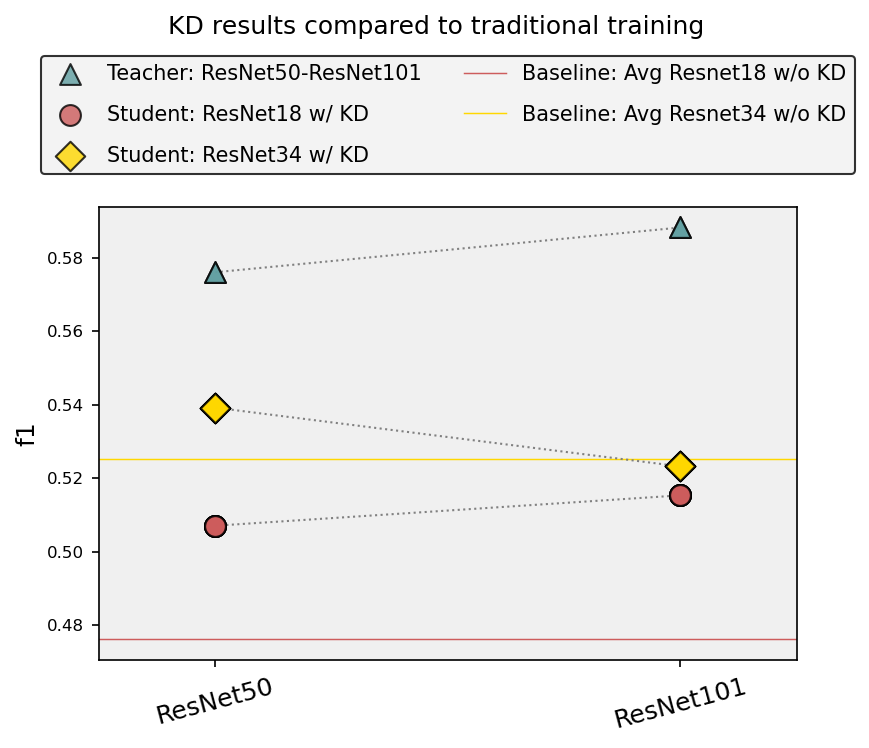

/tmp/ipykernel_2800557/2608185210.py:84: UserWarning:

FixedFormatter should only be used together with FixedLocator



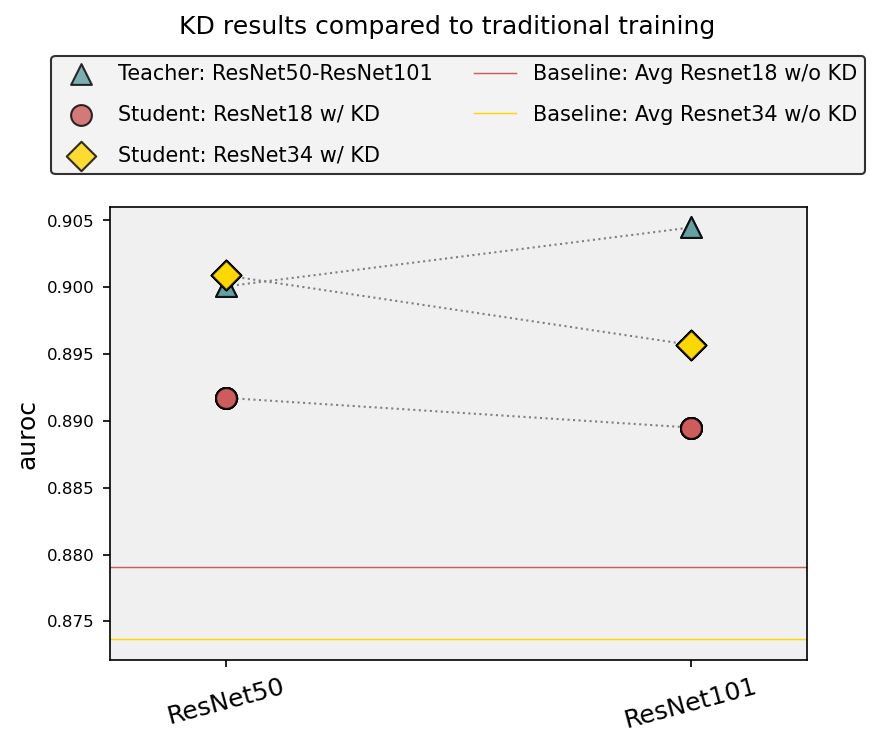

/tmp/ipykernel_2800557/2608185210.py:84: UserWarning:

FixedFormatter should only be used together with FixedLocator



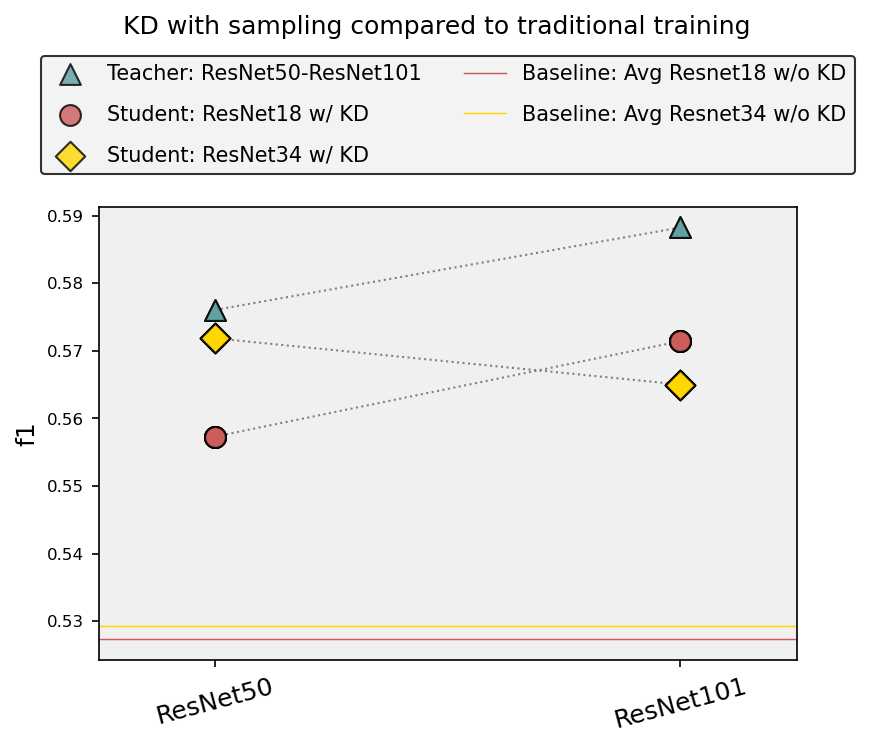

/tmp/ipykernel_2800557/2608185210.py:84: UserWarning:

FixedFormatter should only be used together with FixedLocator



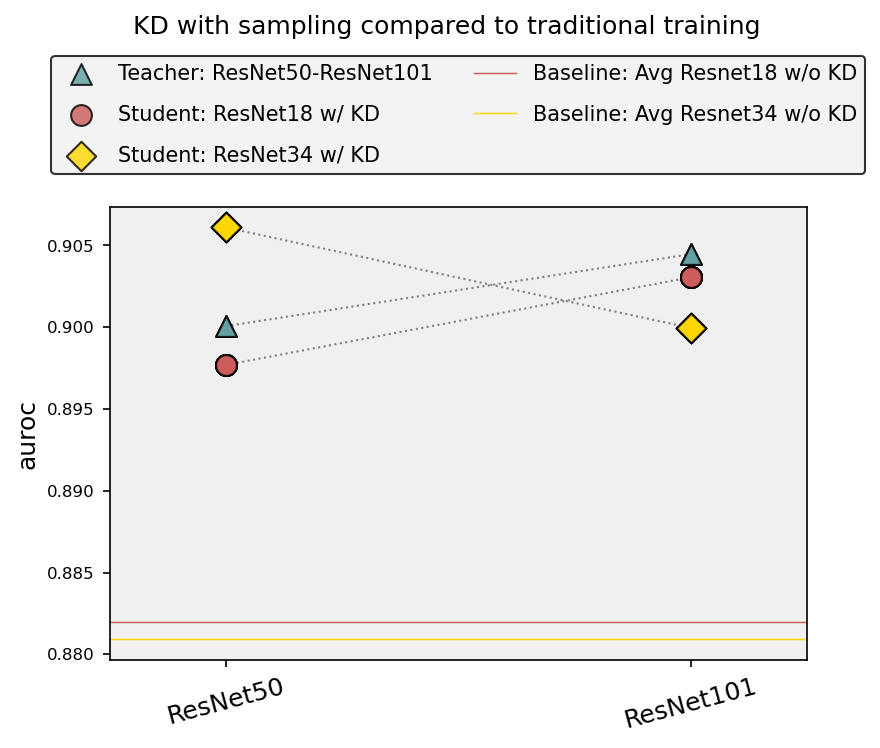

In [78]:
# Predefine teacher models

# teachers=[('resnet101', 'resnet/ft_sampling_load', 43),
#           ('resnet50', 'resnet/ft_sampling_load', 44),
#           ('resnet101', 'resnet/ft_load', 43)]

# TO DO WITHOUT RESNET101 TEACHER WITHOUT SAMPLING
teachers=[('resnet101', 'resnet/ft_sampling_load', 43),
          ('resnet50', 'resnet/ft_sampling_load', 44)]

test_df = test_df.drop(test_df[(test_df['teacher_model'] == 'resnet101')].index)

students=['resnet18', 'resnet34']

# FINE TUNING
plot_kd_performance(test_df, 
                    ('resnet/ft_load', 'kd/ft', '', ''),
                    teachers,
                    students,
                    'f1',
                    title='KD results compared to traditional training', 
                    show_baseline=True, 
                    exp_label_1='Teacher: ResNet50-ResNet101', 
                    exp_label_2='Student: ResNet18 w/ KD',
                    exp_label_3='Student: ResNet34 w/ KD', 
                    exp_label_4='')

plot_kd_performance(test_df, 
                    ('resnet/ft_load', 'kd/ft', '', ''),
                    teachers,
                    students,
                    'auroc',
                    title='KD results compared to traditional training', 
                    show_baseline=True, 
                    exp_label_1='Teacher: ResNet50-ResNet101', 
                    exp_label_2='Student: ResNet18 w/ KD',
                    exp_label_3='Student: ResNet34 w/ KD', 
                    exp_label_4='')

# FINE TUNING + SAMPLING
plot_kd_performance(test_df, 
                    ('resnet/ft_sampling_load', 'kd/ft_sampling', '', ''),
                    teachers,
                    students,
                    'f1',
                    title='KD with sampling compared to traditional training', 
                    show_baseline=True, 
                    exp_label_1='Teacher: ResNet50-ResNet101', 
                    exp_label_2='Student: ResNet18 w/ KD',
                    exp_label_3='Student: ResNet34 w/ KD', 
                    exp_label_4='')

plot_kd_performance(test_df, 
                    ('resnet/ft_sampling_load', 'kd/ft_sampling', '', ''),
                    teachers,
                    students,
                    'auroc',
                    title='KD with sampling compared to traditional training', 
                    show_baseline=True, 
                    exp_label_1='Teacher: ResNet50-ResNet101', 
                    exp_label_2='Student: ResNet18 w/ KD',
                    exp_label_3='Student: ResNet34 w/ KD', 
                    exp_label_4='')

## Subgroup Performance

### Subgroup Performance for Teacher models

In [35]:
def round_to_nearest_multiple_of_5(number):
    return round(number / 5) * 5

def get_subgroup_j_statistic_from_teacher_model(subgroup_df, model_name, experiment, seed):
    assert model_name in ("resnet18", "resnet34", "resnet50", "resnet101", "resnet152")
    subgroups = ['age', 'sex']
    j_group_names = ['J_change_group_0', 'J_change_group_1']
    
    data = []
    for subgroup in subgroups:
        for j_group in j_group_names:
            mask = (subgroup_df['subgroup'] == subgroup) & (subgroup_df['model'] == model_name) & (subgroup_df['experiment'] == experiment) & (subgroup_df['seed'] == seed)
            data.append(subgroup_df.loc[mask][j_group].values[0])
            
    return data

def calculate_teacher_subgroup_disparity(data, teachers):
    # Collect teacher data
    teacher_data = []
    for teacher_params in teachers:
        teacher, _, exp, seed = teacher_params
        teacher_data.append(data[(data['model']==teacher) & (data['seed']==seed) & (data['experiment']==exp)])              
    teacher_df = pd.concat(teacher_data)  

    # Calculate J_stat for each group
    teacher_df['J_statistic_group_0'] = teacher_df['tpr_group_0'] + teacher_df['tnr_group_0'] - 1
    teacher_df['J_statistic_group_1'] = teacher_df['tpr_group_1'] + teacher_df['tnr_group_1'] - 1

    # Calculate average J_stat.
    avg_df = teacher_df.groupby(['model', 'experiment', 'seed'])['J_statistic_group_0', 'J_statistic_group_1'].mean().mean(axis=1)
    avg_df.name = 'J_statistic'
    teacher_df = teacher_df.merge(avg_df, left_on=['model', 'experiment', 'seed'], right_index=True, how='left')
    
    # # Calculate relative change
    teacher_df['J_change_group_0'] = 100 * (teacher_df['J_statistic_group_0'] - teacher_df['J_statistic']) / teacher_df['J_statistic']
    teacher_df['J_change_group_1'] = 100 * (teacher_df['J_statistic_group_1'] - teacher_df['J_statistic']) / teacher_df['J_statistic']
    columns = {'subgroup': []}
    j_change_df = pd.DataFrame(columns)
    j_change_df['subgroup'] = ['age < 60', 'age 60+', 'male', 'female']

    for teacher_params in teachers:
        teacher, teacher_name, exp, seed = teacher_params
        j_change_df[teacher_name] = get_subgroup_j_statistic_from_teacher_model(teacher_df, teacher, exp, seed)
        
    return j_change_df


def plot_subgroup_disparity_for_teachers(data, teachers):
    data = calculate_teacher_subgroup_disparity(data, teachers)

    # plot the data with spacing between bars for each subgroup
    bar_width, bar_spacing = 0.12, 0.02
    fig, ax = plt.subplots(figsize=(10,5))
    for i, teacher_params in enumerate(teachers):
        _, teacher_name, experiment, _ = teacher_params
        x = np.arange(len(data['subgroup']))
        x = x + (i - len(teachers) // 2) * (bar_width + bar_spacing)
        ax.bar(x, data[teacher_name], width=bar_width, label=teacher_name, zorder=3)

    ax.set_xticks(np.arange(len(data['subgroup'])))
    ax.set_xticklabels(data['subgroup'])
    ax.legend()

    ax.grid(axis='y', zorder=0)
    grid_lines = ax.get_ygridlines()
    for line in grid_lines:
        line.set_color('lightgrey')
    
    ax.set_title("Relative change in disease detection performance across patient \nsubgroups in teacher models", fontsize=14)
    ax.set_xlabel('Subgroups', fontsize=14)
    ax.set_ylabel('Difference in % from average\n Youden\'s J statistic', fontsize=14)
    
    numeric_data = data.select_dtypes(include='number').values.tolist()
    
    min_value = round_to_nearest_multiple_of_5(np.min(numeric_data)) - 5
    max_value = round_to_nearest_multiple_of_5(np.max(numeric_data)) + 10
    ax.set_yticks(np.arange(min_value, max_value, 5))
    
    ax.set_facecolor('#F0F0F0')
    plt.show()
    
# Youden’s J statistic 
# J=sensitivity+specificity−1
# J = TPR + TNR - 1

/tmp/ipykernel_3572771/477353806.py:30: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



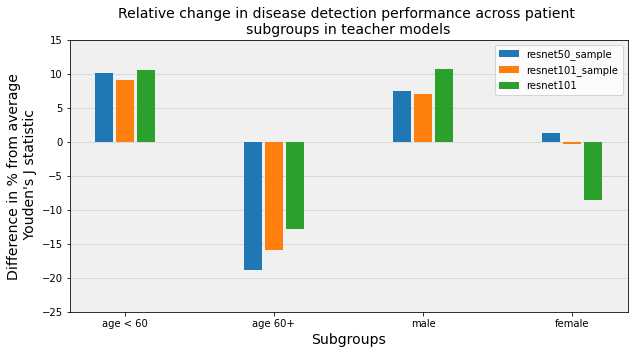

In [36]:
teachers=[('resnet50', 'resnet50_sample', 'resnet/ft_sampling_load', 44),
          ('resnet101', 'resnet101_sample', 'resnet/ft_sampling_load', 43),
          ('resnet101', 'resnet101', 'resnet/ft_load', 43)]


plot_subgroup_disparity_for_teachers(test_df, teachers)

# TODO: Change the title of this plot

### Subgroup Performance for Student Models (These can be averaged across multiple seeds)

In [37]:
def round_to_nearest_multiple_of_5(number):
    return round(number / 5) * 5

def get_subgroup_j_statistic_from_student_model(subgroup_df, model_name, experiment):
    assert model_name in ("resnet18", "resnet34", "resnet50", "resnet101", "resnet152")
    subgroups = ['age', 'sex']
    j_group_names = ['J_change_group_0', 'J_change_group_1']
    
    data = []
    for subgroup in subgroups:
        for j_group in j_group_names:
            mask = (subgroup_df['subgroup'] == subgroup) & (subgroup_df['model'] == model_name) & (subgroup_df['experiment'] == experiment)
            data.append(subgroup_df.loc[mask][j_group].mean())
            
    return data

def calculate_student_subgroup_disparity(data, students, experiment, teacher=None):
    # Collect teacher data
    student_data = []
    for student in students:
        if teacher is not None:
            student_data.append(data[(data['model']==student) & (data['experiment']==experiment) & (data['teacher_model']==teacher)])      
        else:
            student_data.append(data[(data['model']==student) & (data['experiment']==experiment)])          
    student_df = pd.concat(student_data) 

    # Calculate J_stat for each group
    student_df['J_statistic_group_0'] = student_df['tpr_group_0'] + student_df['tnr_group_0'] - 1
    student_df['J_statistic_group_1'] = student_df['tpr_group_1'] + student_df['tnr_group_1'] - 1

    # Calculate average J_stat.
    avg_df = student_df.groupby(['model', 'experiment'])['J_statistic_group_0', 'J_statistic_group_1'].mean().mean(axis=1)
    avg_df.name = 'J_statistic'
    student_df = student_df.merge(avg_df, left_on=['model', 'experiment'], right_index=True, how='left')
    
    # # Calculate relative change
    student_df['J_change_group_0'] = 100 * (student_df['J_statistic_group_0'] - student_df['J_statistic']) / student_df['J_statistic']
    student_df['J_change_group_1'] = 100 * (student_df['J_statistic_group_1'] - student_df['J_statistic']) / student_df['J_statistic']

    student_df.to_csv('student_df.csv')
    
    columns = {'subgroup': []}
    j_change_df = pd.DataFrame(columns)
    j_change_df['subgroup'] = ['age < 60', 'age 60+', 'male', 'female']

    for student in students:
        j_change_df[student] = get_subgroup_j_statistic_from_student_model(student_df, student, experiment)
        
    return j_change_df


def plot_subgroup_disparity_for_students(data, students, experiment, teacher=None):
    data = calculate_student_subgroup_disparity(data, students, experiment, teacher)

    # plot the data with spacing between bars for each subgroup
    bar_width = 0.12
    bar_spacing = 0.02

    fig, ax = plt.subplots(figsize=(10,5))
    for i, model in enumerate(students):
        x = np.arange(len(data['subgroup']))
        x = x + (i - len(students) // 2) * (bar_width + bar_spacing)
        ax.bar(x, data[model], width=bar_width, label=model, zorder=3)

    ax.set_xticks(np.arange(len(data['subgroup'])))
    ax.set_xticklabels(data['subgroup'])
    ax.legend()

    ax.grid(axis='y', zorder=0)
    grid_lines = ax.get_ygridlines()
    for line in grid_lines:
        line.set_color('lightgrey')
    
    ax.set_title("Relative change in disease detection performance across patient \nsubgroups in " + experiment + " experiment", fontsize=14)
    ax.set_xlabel('Subgroups', fontsize=14)
    ax.set_ylabel('Difference in % from average\n Youden\'s J statistic', fontsize=14)
    
    numeric_data = data.select_dtypes(include='number').values.tolist()
    
    min_value = round_to_nearest_multiple_of_5(np.min(numeric_data)) - 5
    max_value = round_to_nearest_multiple_of_5(np.max(numeric_data)) + 10
    ax.set_yticks(np.arange(min_value, max_value, 5))
    
    ax.set_facecolor('#F0F0F0')
    
    plt.show()

/tmp/ipykernel_3572771/3692814375.py:32: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



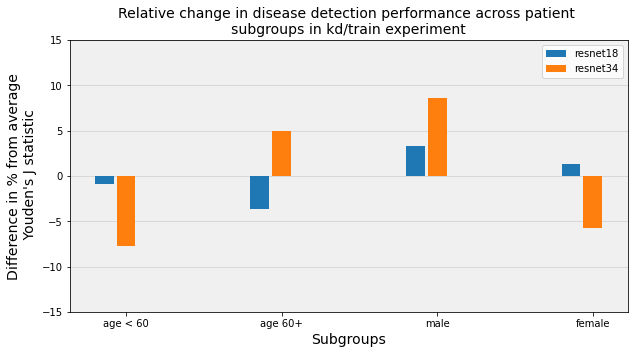

/tmp/ipykernel_3572771/3692814375.py:32: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



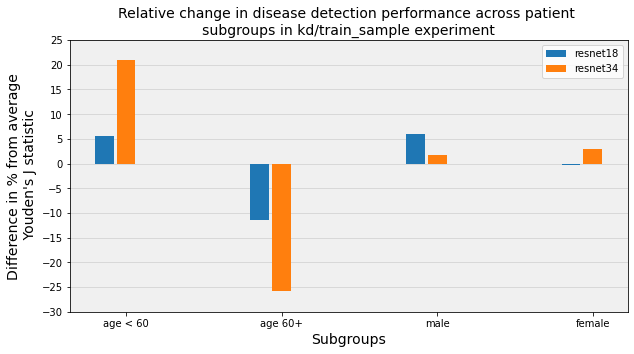

/tmp/ipykernel_3572771/3692814375.py:32: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



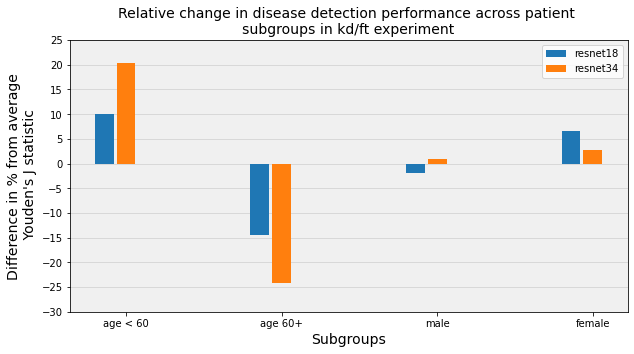

/tmp/ipykernel_3572771/3692814375.py:32: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



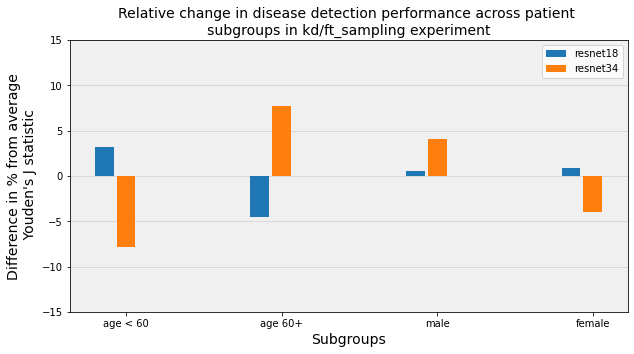

In [47]:
students = ['resnet18', 'resnet34']

for experiment in ['kd/train', 'kd/train_sample', 'kd/ft', 'kd/ft_sampling']:
    plot_subgroup_disparity_for_students(test_df, students, experiment, 'resnet101')

# Can also speciufy a particular teacher
# TODO: An this to the title
# plot_subgroup_disparity_for_students(test_df, students, 'kd/ft', 'resnet101')

# TODO: Make a plot with a teacher and a student model at once